# Introduction

We need a huge amount of images data to train model that is capable of restoring old photos. The image data should be in pair i.e. a pair must contain one image that is in degraded/old form and another image must be restored version of that image. Since, internet is filled with clean digital image it is very difficult to find such image data sets. So, we download the clean images from the internet and modify them to look degraded. 

Here, we are using [places dataset](http://places.csail.mit.edu/). There are around 2.5 million images from 205 scene categories. 100 images per category for validation set and 200 images for test set in this dataset. 

But we are downloading subset of this dataset that contains 41 thousands images that are resized to 256x256x3 pixels as we do not have processing capacity to handle full sized dataset.







# Downloading the datset.

There are two ways to download this dataset in google colab paltform. We can directly download data from MIT's server using **wget** tool or we can use **gdown** to download dataset that has been uploaded to google drive platform. It is extremely fast to download dataset from drive so it is preferred. 

---

Both commands are listed below. Un-comment the utility that you want to use and comment the utility that you do not want to use. Running both utility will result in filename clashes.

In [ ]:
# uncomment below command to download datset directly from MIT server. 

# !wget http://data.csail.mit.edu/places/places205/imagesPlaces205_resize.tar.gz

In [2]:
# this cell downloads dataset from google drive

!gdown https://drive.google.com/uc?id=1-CNOtMEBdZna6m5fB9WOjXyGqAcMyor9

Downloading...
From: https://drive.google.com/uc?id=1-CNOtMEBdZna6m5fB9WOjXyGqAcMyor9
To: /content/testSetPlaces205_resize.tar.gz
2.34GB [00:22, 102MB/s]


## Uncompressing the dataset.

Since the dataset has been downloaded in compressed form. It needs to be decompressed. Decompression can be achieved by running the following cell.

In [ ]:
!gunzip < testSetPlaces205_resize.tar.gz | tar xvf -

## Confirming the download and decompression.

In [5]:
# Count the number of files in currently downloaded dataset.

!ls /content/testSet_resize  | echo "There are $(wc -l) images in  testSet_resize directory."

There are 41000 images in  testSet_resize directory.


In [8]:
# Renaming testSet_resize to clean_images.
!mv /content/testSet_resize /content/clean_images

# View top 5 names of file in clean_images directory.
!ls /content/clean_images -U | head -5

mv: cannot stat '/content/testSet_resize': No such file or directory
ef6f039b6901dab45aee8ce8a29be520.jpg
d78e16e1f9e6c214b89e3c26956e3459.jpg
20e41e3693225568b7fb0d94ff983e81.jpg
3409ac46be45ecc29799f51db2847ea9.jpg
63d20119261914303717d7f81ecd235d.jpg


# Creating old/degraded images from clean images.

In this section we will add defects to the images. Since we are modifying the data to generate more data, this is called argumentation.

In [9]:
# making directory to store the clean images.
!mkdir /content/dirty_images

In [10]:
# importing all essential libraries.
import os
import cv2
import random
import numpy as np

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

from IPython.display import clear_output

## Downloading image of crack.

The old photos have cracks in the images. These cracks usually occur when the photographs are folded and unfolded many time. Here we will download image or crack line that we will overlay on the new images to simulate the crack in old photos. The crack image is also stored in publicly accessible google drive and will be downloaded by using **gdown** utility.



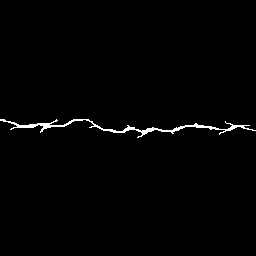


*fig: crack line image*

In [11]:
# Downloading image of crack line.

!gdown https://drive.google.com/uc?id=161WjdVmZie2WlB3KmEEltgTPywjxG09h

Downloading...
From: https://drive.google.com/uc?id=161WjdVmZie2WlB3KmEEltgTPywjxG09h
To: /content/crack.png
100% 1.43k/1.43k [00:00<00:00, 633kB/s]


## Writing methods to argument images.

In this notebook we have only focused on only two methods for generating distorted images from clean images. 



1. **Brightness shift in images:** The brightness of photographs shift due to various reasons. Photos lose their color or have extreme discoloration due to moisture and other environmental consitions. So we have created a function to shift the brightness of image in random fashion. 

2. **Addition of crack in images.** As stated above the images get crack due to folding the folding of photos. These crack ranges from single crack line to multiple crack lines. We have written a method to randomly introduce at least minimum of one crack and upto five cracks in the image. The method uses another *rotate_image()* method to build variation of crack angle in the image.



In [16]:
# this method is used for rotation of crack image. 
def rotate_image(img):
    h, w = img.shape[:2]
    # https://subscription.packtpub.com/book/application_development/9781785283932/1/ch01lvl1sec11/image-translation (referenced from)
    # Image translation
    translation = int(random.uniform(-80, 80))
    translation_matrix = np.float32([[1, 0, 0], [0, 1, translation]])
    img_translation = cv2.warpAffine(img, translation_matrix, (h, w))
    # Image rotation
    angle = int(random.uniform(-360, 360))
    m = cv2.getRotationMatrix2D((int(w / 2), int(h / 2)), angle, 1.5)
    img = cv2.warpAffine(img_translation, m, (w, h))
    return img


# method to shift brightness in image
# https://stackoverflow.com/questions/32609098/how-to-fast-change-image-brightness-with-python-opencv (referenced from)
# Nov 22 '17 at 5:26 | Bill Grates
def brightness_shift(img):
    value = int(random.uniform(60, 0))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value
    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

# method to introduce cracks to a given image.
def get_scratched_image(img):
  # we scratch the image for random amount of times.
  times = random.randint(1,6)
  for _ in range(times):
    # we roates the crack image so that we get different types of scratches each time.
    modified_crack_image = rotate_image(crack_image)
    img =  output_image = cv2.addWeighted(img, 1, modified_crack_image, 1, 0)
  return img

## Method to utilized above argumentation methods.

This method utilizes above methods to read images from *clean_images* directory and modify them to store them in *dirty_images* directory.

In [27]:
# declaring directory paths.
CLEAN_IMAGES = "/content/clean_images"
DIRTY_IMAGES = "/content/dirty_images"
CRACK_IMG = "/content/crack.png"
crack_image = cv2.imread(CRACK_IMG, cv2.IMREAD_UNCHANGED)

def argument_images():
  # This counter keeps track of how many images are processed.
  count = 1
  for filename in os.listdir(CLEAN_IMAGES):
    try:
      input_image = cv2.imread(os.path.join(CLEAN_IMAGES, filename))
      input_image = brightness_shift(input_image)
      input_image = cv2.cvtColor(input_image, cv2.COLOR_RGB2RGBA)
      output_image = get_scratched_image(input_image)
      cv2.imwrite(os.path.join(DIRTY_IMAGES, filename), output_image)
      print("Processing image " + str(count) + " out of 41000 images.")
      count = count+1
      # https://stackoverflow.com/questions/24816237/ipython-notebook-clear-cell-output-in-code/24818304 (Jul 18 '14 at 6:12 | cel)
      clear_output(wait=True)
  
    except Exception as e:
      print(" Oops!", e.__class__, "occurred.")

In [28]:
# Running above method.
argument_images()

Processing image 41000 out of 41000 images.


# Verifying the images.

In [29]:
# Displaying total files in dirty_image directory

!ls /content/dirty_images  | echo "There are $(wc -l) images in  dirty_image directory."

There are 41000 images in  dirty_image directory.


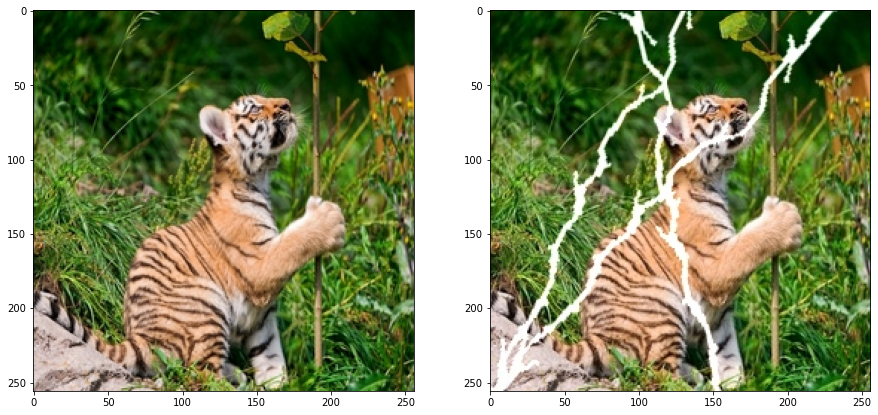

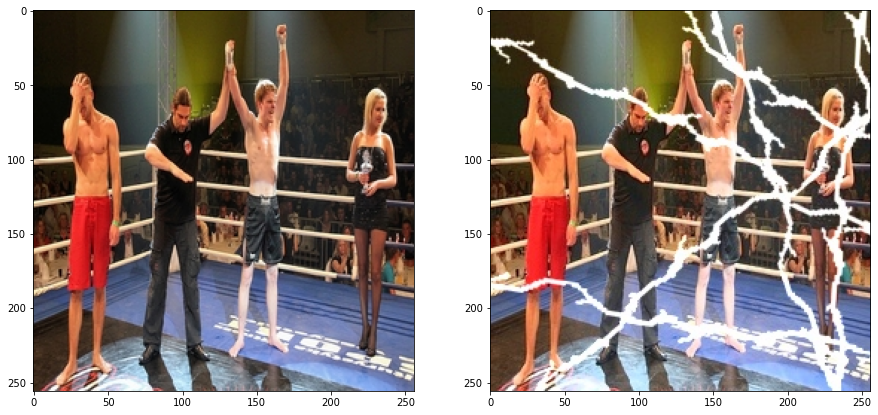

In [53]:
# viewing original and altered images.
import matplotlib
import matplotlib.pyplot as plt

original = cv2.imread('/content/clean_images/0a469db17b99157d6595a1b689370969.jpg')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
altered = cv2.imread('/content/dirty_images/0a469db17b99157d6595a1b689370969.jpg')
altered = cv2.cvtColor(altered, cv2.COLOR_BGR2RGB)

original2 = cv2.imread('/content/clean_images/0c13586fbf9479a286c9b2479680229a.jpg')
original2 = cv2.cvtColor(original2, cv2.COLOR_BGR2RGB)
altered2 = cv2.imread('/content/dirty_images/0c13586fbf9479a286c9b2479680229a.jpg')
altered2 = cv2.cvtColor(altered2, cv2.COLOR_BGR2RGB)

_, axes = plt.subplots(1, 2, figsize=(15, 8))
axes[0].imshow(original)
axes[1].imshow(altered)

_, axes2 = plt.subplots(1, 2, figsize=(15, 8))
axes2[0].imshow(original2)
axes2[1].imshow(altered2)

plt.show()

# Saving the altered images.

We will compress the altered images i.e. dirty images and download/save it for further usage. Since, argumentation takes a really long time it is better to argument at once and use them later.

In [ ]:
# run this cell to compress the file as zip file.

!zip -r dirty_images.zip dirty_images

# Download the zipped file.

Download the zip file that contains dirty image by follwing the following procedures shown in the image.


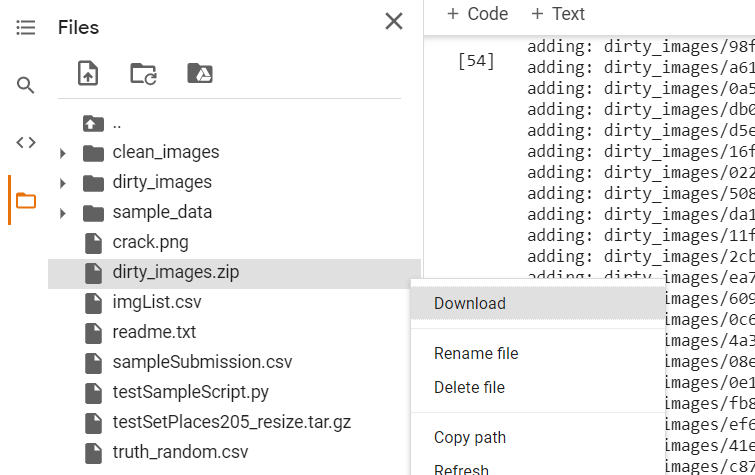

End of **Part 01 - Data preprocessing and argumentation.**